In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve


from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [4]:
train=pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

## Checking for Missing Values

In [5]:
test.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

## Checking Distribution of Target Variable 

In [6]:
train.shape

(2190, 13)

In [7]:
train['rainfall'].value_counts(normalize=True)

rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64

In [8]:
train.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [9]:
train['day'].describe()

count    2190.000000
mean      179.948402
std       105.203592
min         1.000000
25%        89.000000
50%       178.500000
75%       270.000000
max       365.000000
Name: day, dtype: float64

In [10]:
train['year']=train['id']//365 + 1
train.groupby(train['year'])['day'].describe()

test['year']=test['id']//365 + 1
test.groupby(test['year'])['day'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
7,365.0,183.0,105.510663,1.0,92.0,183.0,274.0,365.0
8,365.0,183.0,105.510663,1.0,92.0,183.0,274.0,365.0


In [11]:
## Checking for missing values

missing_proportions = {}
for col in train.columns:
    missing_proportions[col] = train[col].isnull().sum()

print(missing_proportions)

{'id': 0, 'day': 0, 'pressure': 0, 'maxtemp': 0, 'temparature': 0, 'mintemp': 0, 'dewpoint': 0, 'humidity': 0, 'cloud': 0, 'sunshine': 0, 'winddirection': 0, 'windspeed': 0, 'rainfall': 0, 'year': 0}


## EDA And Visualization

### Boxplots of Explanatory variables segmented by Target classification

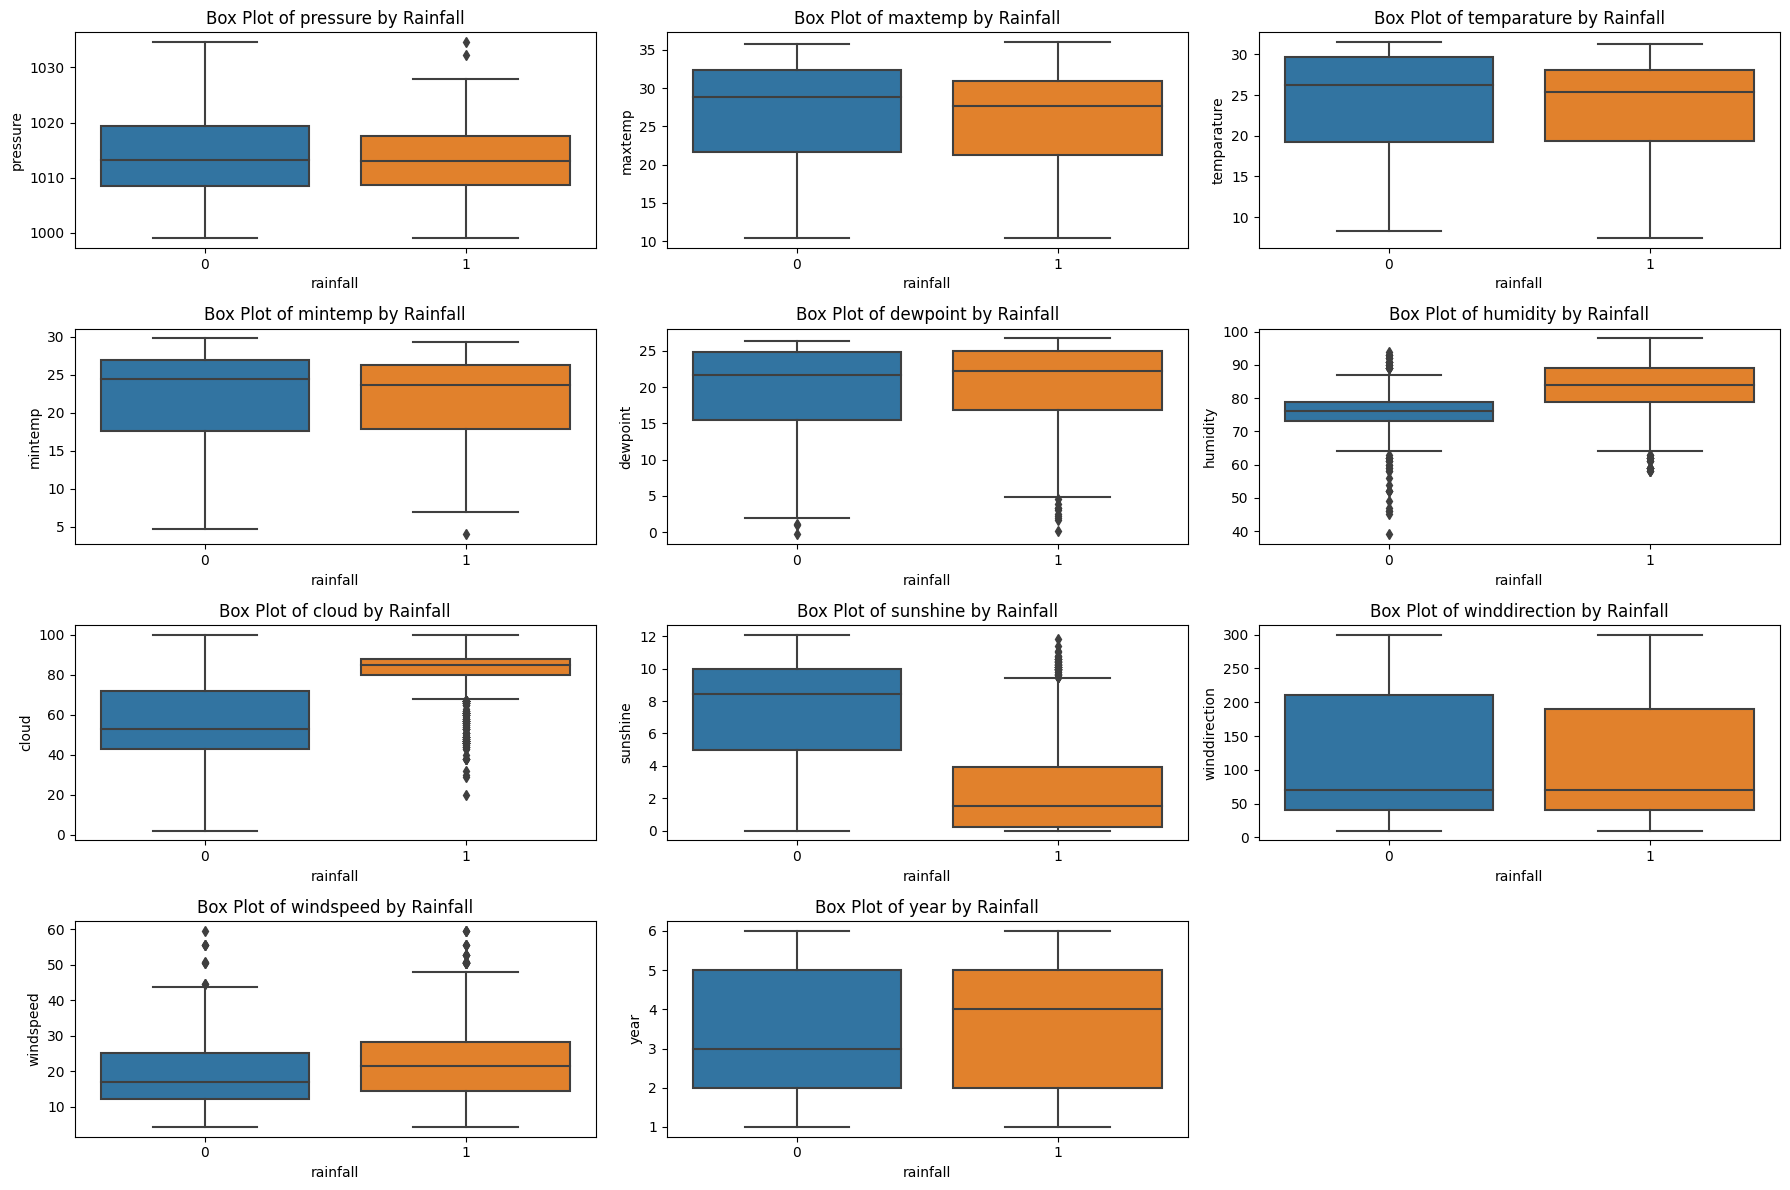

In [12]:
continuous_vars = list(train.drop(columns=['id','day','rainfall']).columns)

# Create subplots
num_cols = 3
num_rows = -(-len(continuous_vars) // num_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))  
axes = axes.flatten()

for i, var in enumerate(continuous_vars):
    sns.boxplot(x='rainfall', y=var, data=train, ax=axes[i])
    axes[i].set_title(f"Box Plot of {var} by Rainfall")



for j in range(len(continuous_vars), len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

In [13]:
# import matplotlib.pyplot as plt

# # Ensure 'year' column exists
# train['year'] = train['id'] // 365 + 1

# # Get unique years
# years = train['year'].unique()

# # Set up subplots
# fig, axes = plt.subplots(len(years), 1, figsize=(12, 4 * len(years)), sharex=True, sharey=True)

# # If only one year, convert axes to a list
# if len(years) == 1:
#     axes = [axes]

# # Plot each year separately
# for i, year in enumerate(years):
#     subset = train[train['year'] == year]
#     axes[i].plot(subset['day'], subset['rainfall'], linestyle='-', marker='o', markersize=2, color='blue', alpha=0.7)
#     axes[i].set_title(f'Binary Rainfall Time Series - Year {year}')
#     axes[i].set_ylabel('Rain (1=Yes, 0=No)')

# # Common X-label
# plt.xlabel('Day of Year')
# plt.tight_layout()
# plt.show()


## Feature Engineering


In [14]:
test['id'].describe()

count     730.000000
mean     2554.500000
std       210.877136
min      2190.000000
25%      2372.250000
50%      2554.500000
75%      2736.750000
max      2919.000000
Name: id, dtype: float64

### Creating variable transformations - squared, lag 1, and moving averages

In [15]:
def feature_engineering(df, dataset_type):
    df=df.sort_values(by=['id'])
    df['temp_diff'] = df['maxtemp'] - df['mintemp']
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2

    for i in df.columns:
        df[f'{i}'] = df[i].fillna(method='ffill')

    if dataset_type == 'train':
        for i in df.drop(columns=['id', 'day', 'rainfall']).columns:
            df[f'{i}_m_avg']=df[i].rolling(window=5).mean().fillna(df[i].mean())
            df[f'{i}_sqr'] = df[i] ** 2
            df[f'{i}_lagged']=df[i].shift(1).fillna(df[i].mean())

    elif dataset_type == 'test':
        for i in df.drop(columns=['id', 'day']).columns:
            df[f'{i}_m_avg']=df[i].rolling(window=5).mean().fillna(df[i].mean())
            df[f'{i}_sqr'] = df[i] ** 2
            df[f'{i}_lagged']=df[i].shift(1).fillna(df[i].mean())


    return df

In [16]:
train_final=feature_engineering(train,'train')


<ipython-input-15-a98eba8bf782>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{i}'] = df[i].fillna(method='ffill')


In [17]:
train_final.isna().mean()

id                      0.0
day                     0.0
pressure                0.0
maxtemp                 0.0
temparature             0.0
mintemp                 0.0
dewpoint                0.0
humidity                0.0
cloud                   0.0
sunshine                0.0
winddirection           0.0
windspeed               0.0
rainfall                0.0
year                    0.0
temp_diff               0.0
avg_temp                0.0
pressure_m_avg          0.0
pressure_sqr            0.0
pressure_lagged         0.0
maxtemp_m_avg           0.0
maxtemp_sqr             0.0
maxtemp_lagged          0.0
temparature_m_avg       0.0
temparature_sqr         0.0
temparature_lagged      0.0
mintemp_m_avg           0.0
mintemp_sqr             0.0
mintemp_lagged          0.0
dewpoint_m_avg          0.0
dewpoint_sqr            0.0
dewpoint_lagged         0.0
humidity_m_avg          0.0
humidity_sqr            0.0
humidity_lagged         0.0
cloud_m_avg             0.0
cloud_sqr           

In [18]:
test_final=feature_engineering(test,'test')

<ipython-input-15-a98eba8bf782>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{i}'] = df[i].fillna(method='ffill')


In [19]:
test_final.isna().mean()

id                      0.0
day                     0.0
pressure                0.0
maxtemp                 0.0
temparature             0.0
mintemp                 0.0
dewpoint                0.0
humidity                0.0
cloud                   0.0
sunshine                0.0
winddirection           0.0
windspeed               0.0
year                    0.0
temp_diff               0.0
avg_temp                0.0
pressure_m_avg          0.0
pressure_sqr            0.0
pressure_lagged         0.0
maxtemp_m_avg           0.0
maxtemp_sqr             0.0
maxtemp_lagged          0.0
temparature_m_avg       0.0
temparature_sqr         0.0
temparature_lagged      0.0
mintemp_m_avg           0.0
mintemp_sqr             0.0
mintemp_lagged          0.0
dewpoint_m_avg          0.0
dewpoint_sqr            0.0
dewpoint_lagged         0.0
humidity_m_avg          0.0
humidity_sqr            0.0
humidity_lagged         0.0
cloud_m_avg             0.0
cloud_sqr               0.0
cloud_lagged        

## Performing PCA

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = train_final.drop('rainfall', axis=1)
y = train_final['rainfall']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

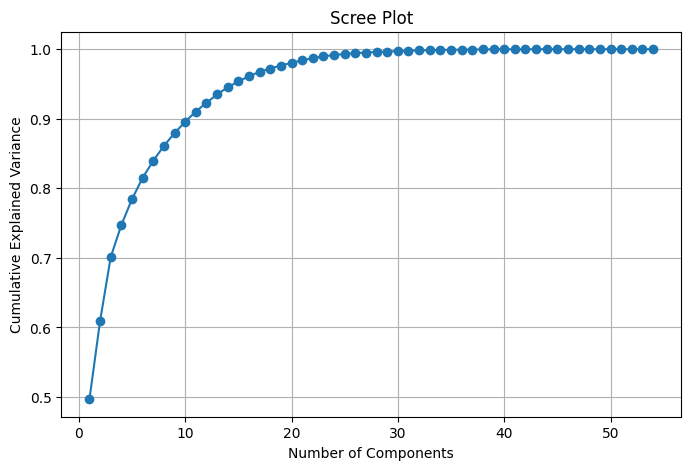

In [21]:
pca = PCA()
pca.fit(X_scaled)

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

In [22]:
ideal_comp=15
pca = PCA(n_components=ideal_comp)  
principal_components = pca.fit_transform(X_scaled)

# Convert to DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC_{i}' for i in range(1,ideal_comp+1)])

# Explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Visualize the results
# plt.figure(figsize=(8, 6))
# plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA Visualization')
# plt.grid()
# plt.show()

Explained Variance Ratio: [0.4968309  0.11266059 0.09167082 0.04623744 0.03705905 0.03068165
 0.02452194 0.02138985 0.01829321 0.01635237 0.01473876 0.01246559
 0.01216189 0.01004486 0.00857872]


In [23]:
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(ideal_comp)])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,2.034302,-1.361270,-2.018965,0.800991,-1.042721,-1.291219,-1.287694,-0.229447,-0.156010,1.733254,-0.375322,-0.962139,-0.051457,-0.455706,-1.085686
1,4.694651,-2.327784,-2.730824,0.441403,-0.861431,-1.448311,-1.566087,-0.825578,-0.042179,0.227825,-0.242566,-2.577918,0.197699,-0.393983,-1.431338
2,4.876427,2.975361,-2.667362,-3.776831,0.167462,0.187648,-1.267694,-0.828628,-0.116875,-0.564486,-0.714901,-1.605966,-0.371406,-0.912232,-1.127658
3,4.630770,-1.142578,-2.665055,4.196449,-0.474265,-0.606713,-2.032429,-1.542058,-0.342917,0.105388,-0.273945,-0.194068,0.386525,0.547268,0.167834
4,5.911441,4.125456,-3.170347,-4.329448,1.605153,1.345435,-0.202735,1.167458,-0.443617,0.978205,-2.698577,-0.976125,-0.017241,-1.355719,0.169481


## Fitting Decision Tree - Basic model to understand variable importance and setting baseline metrics


In [33]:

X=pca_df
y=train_final['rainfall']

In [34]:


X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y,test_size=0.2, random_state=42)
# X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [35]:
y_train.shape

(1752,)

In [36]:
# smote = SMOTE(sampling_strategy='auto', random_state=42,k_neighbors=5)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [37]:
y_train.value_counts()
# y_train_resampled.value_counts()

rainfall
1    1320
0     432
Name: count, dtype: int64

In [38]:
clf = DecisionTreeClassifier(max_depth=5,random_state=42,min_samples_leaf=round(len(X_train)/100))
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=18, random_state=42)

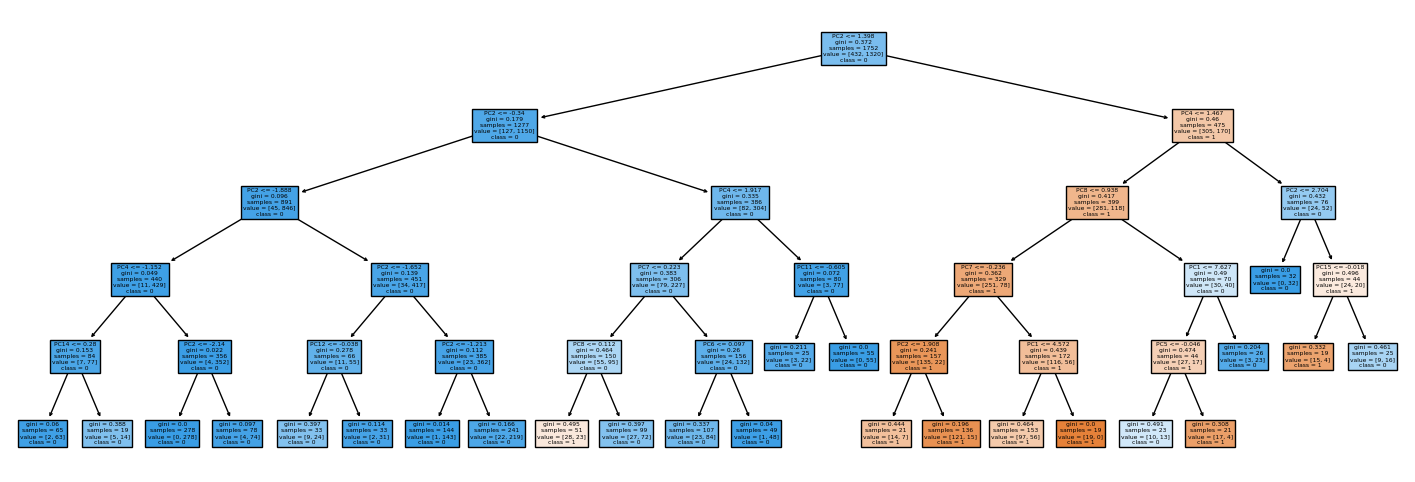

In [39]:
plt.figure(figsize=(18, 6))
class_names = [str(cls) for cls in y_train.unique()] 
plot_tree(clf, feature_names=X_train.columns, class_names=class_names, filled=True)

plt.savefig("decision_tree_rainfall_pca.png", dpi=500, bbox_inches='tight')
plt.show()


In [40]:
y_pred = clf.predict(X_test)


In [41]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8265
Precision: 0.8780
Recall: 0.8939
F1-score: 0.8859

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.62      0.64       108
           1       0.88      0.89      0.89       330

    accuracy                           0.83       438
   macro avg       0.77      0.76      0.76       438
weighted avg       0.82      0.83      0.82       438



> *The recall for the minority class is low as expected. We will be using undersampling and oversampling methods to improve this metric*>**** **

In [42]:

y_probs = clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Select threshold where precision and recall are balanced
optimal_idx = (precision + recall).argmax()
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)
# Make new predictions
y_pred_new = (y_probs > optimal_threshold).astype(int)

0.45098039215686275


## Logistic Regression


In [119]:
y_train.value_counts()

rainfall
1    1320
0     432
Name: count, dtype: int64

In [ ]:
# smote = SMOTE(sampling_strategy=0.5, random_state=42,k_neighbors=2)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)

X_smote, y_smote=X_train,y_train
# Initialize NearMiss for all versions
nearmiss_v1 = NearMiss(version=1,sampling_strategy=0.5,n_neighbors_ver3=2)
nearmiss_v2 = NearMiss(version=2,sampling_strategy=0.5,n_neighbors_ver3=2)
nearmiss_v3 = NearMiss(version=3,sampling_strategy=0.5,n_neighbors_ver3=2)

# Apply NearMiss after SMOTE
X_nm1, y_nm1 = nearmiss_v1.fit_resample(X_smote, y_smote)
X_nm2, y_nm2 = nearmiss_v2.fit_resample(X_smote, y_smote)
X_nm3, y_nm3 = nearmiss_v3.fit_resample(X_smote, y_smote)

# Plotting function
def plot_data(X, y, title, ax):
    colors = ['blue' if label == 1 else 'red' for label in y]
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors, edgecolor='k', s=25)
    ax.set_title(title)

# Create the plot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Original data
plot_data(X, y, 'Original Data', axs[0, 0])

# After SMOTE
plot_data(X_smote, y_smote, 'After SMOTE (0.5)', axs[0, 1])

# NearMiss Versions After SMOTE
plot_data(X_nm1, y_nm1, 'NearMiss V1 After SMOTE', axs[0, 2])
plot_data(X_nm2, y_nm2, 'NearMiss V2 After SMOTE', axs[1, 0])
plot_data(X_nm3, y_nm3, 'NearMiss V3 After SMOTE', axs[1, 1])

# Hide empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.savefig("Only_nearmiss_viz.png", dpi=500, bbox_inches='tight')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, make_scorer, recall_score


lr_pipeline = Pipeline([
    ('nearmiss', NearMiss(version=3,sampling_strategy=0.5)),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# param_grid = {
#     'smote__sampling_strategy': [ 0.5, 0.7],
#     'smote__k_neighbors': [3, 5, 7],
#     'nearmiss__version': [1, 2, 3],
#     'nearmiss__n_neighbors': [3, 5, 7, 10],
#     'nearmiss__sampling_strategy': [0.3, 0.5, 0.7]
# }

# scorer = make_scorer(f1_score, average='binary')  

# grid_search = GridSearchCV(lr_pipeline, param_grid, scoring=scorer, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)


# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)



In [109]:
# best_lr_model = grid_search.best_estimator_
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Accuracy: 0.8676
Precision: 0.8977
Recall: 0.9303
F1-score: 0.9137

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72       108
           1       0.90      0.93      0.91       330

    accuracy                           0.87       438
   macro avg       0.83      0.80      0.81       438
weighted avg       0.86      0.87      0.86       438



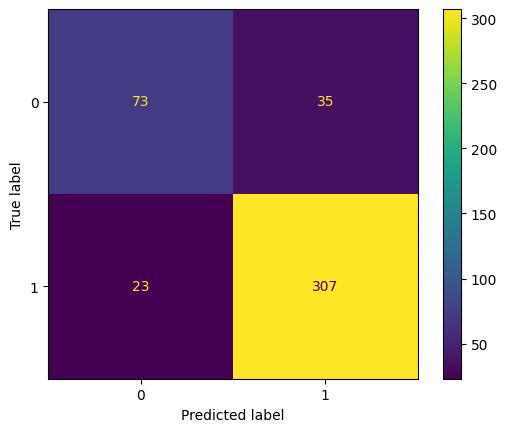

In [110]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred, labels=best_lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_lr_model.classes_)
disp.plot()

plt.show()

In [112]:
X_test_scaled = scaler.transform(test_final)
X_test_pca = pca.transform(X_test_scaled)
y_pred_submit = lr_pipeline.predict_proba(X_test_pca)[:, 1] 
submission = pd.DataFrame({
    "id": test["id"],  
    "rainfall": y_pred_submit  
})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Random Forest Classification

#### RandomizedSearch CV with Pre-determined NearMiss strategy

In [114]:
rf_pipeline = Pipeline([
    ('nearmiss', NearMiss(version=3,sampling_strategy=0.5)),
    ('model', RandomForestClassifier(random_state=42))
])

param_distributions = {
    'model__n_estimators': [200, 400, 600, 800, 1000],
    'model__max_depth': [5, 10, 15, 20, 30, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 5, 10, 15, 30],
    'model__max_features': ['sqrt', 'log2', None],
    'model__bootstrap': [True, False],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__ccp_alpha': [0.0, 0.01, 0.1, 1.0],
    'model__max_samples': [0.5, 0.7, 0.9, None]
}



opt = RandomizedSearchCV(rf_pipeline, param_distributions, n_iter=30, cv=5, scoring='f1', n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/utils/fixes.py", line 85, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/usr/local

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('nearmiss',
                                              NearMiss(sampling_strategy=0.5,
                                                       version=3)),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__ccp_alpha': [0.0, 0.01, 0.1,
                                                             1.0],
                                        'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [5, 10, 15, 20, 30,
                                                             None],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__max_samples': [0.5, 0.7, 0.9,
                                                               None],
                                        'model__min_samples_leaf': [1, 5, 10,
                                                                    15, 30],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20],
                                        'model__n_estimators': [200, 400, 600,
                                                                800, 1000]},
                   random_state=42, scoring='f1')

In [115]:
# Print best parameters
print("Best Parameters:", opt.best_params_)

Best Parameters: {'model__n_estimators': 800, 'model__min_samples_split': 2, 'model__min_samples_leaf': 5, 'model__max_samples': 0.5, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__criterion': 'log_loss', 'model__ccp_alpha': 0.0, 'model__bootstrap': True}


In [116]:
best_params = opt.best_params_

# Extract only RandomForest parameters
rf_params = {k.replace('model__', ''): v for k, v in best_params.items() if k.startswith('model__')}

# Train RandomForest with the best parameters
clf_rf = RandomForestClassifier(**rf_params, random_state=42)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='log2',
                       max_samples=0.5, min_samples_leaf=5, n_estimators=800,
                       random_state=42)

In [117]:
y_pred = clf_rf.predict(X_test)

In [118]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8584
Precision: 0.8702
Recall: 0.9545
F1-score: 0.9104

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.56      0.66       108
           1       0.87      0.95      0.91       330

    accuracy                           0.86       438
   macro avg       0.84      0.76      0.79       438
weighted avg       0.85      0.86      0.85       438



### Random Search Optimization of Hyperparameters


In [105]:


# Define the pipeline (SMOTE + RandomForest)
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

# Define parameter distributions correctly
param_distributions = {
    # SMOTE Parameters
    'smote__sampling_strategy': [0.5, 0.7, 'auto'],
    'smote__k_neighbors': [3, 5, 7, 10],

    # Random Forest Parameters
    'model__n_estimators': [200, 400, 600, 800, 1000],
    'model__max_depth': [5, 10, 15, 20, 30, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 5, 10, 15, 30],
    'model__max_features': ['sqrt', 'log2', None],
    'model__bootstrap': [True, False],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__ccp_alpha': [0.0, 0.01, 0.1, 1.0],
    'model__max_samples': [0.5, 0.7, 0.9, None]
}



opt = RandomizedSearchCV(pipeline, param_distributions, n_iter=30, cv=5, scoring='f1', n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", opt.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/utils/fixes.py", line 85, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/usr/local

Best Parameters: {'smote__sampling_strategy': 0.5, 'smote__k_neighbors': 10, 'model__n_estimators': 1000, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10, 'model__max_samples': 0.9, 'model__max_features': 'log2', 'model__max_depth': 20, 'model__criterion': 'entropy', 'model__ccp_alpha': 0.0, 'model__bootstrap': True}


## Bayesian Optimization of Hyperparameters


In [106]:


pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])


param_distributions = {
    # SMOTE Parameters
    'smote__sampling_strategy': [0.5, 0.7, 'auto'],
    'smote__k_neighbors': [3, 5, 7, 10],

    # Random Forest Parameters
    'model__n_estimators': [200, 400, 600, 800, 1000],
    'model__max_depth': [5, 10, 15, 20, 30, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 5, 10, 15, 30],
    'model__max_features': ['sqrt', 'log2', None],
    'model__bootstrap': [True, False],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__ccp_alpha': [0.0, 0.01, 0.1, 1.0],
    'model__max_samples': [0.5, 0.7, 0.9, None]
}


# Perform Bayesian Optimization with Cross-Validation
opt_bayes = BayesSearchCV(pipeline, param_space, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42)
opt_bayes.fit(X_train, y_train)





BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                        ('model',
                                         RandomForestClassifier(random_state=42))]),
              n_iter=20, n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'model__max_depth': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'model__max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'model__min_samples_leaf': Integer(low=5, high=30, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=200, high=800, prior='uniform', transform='normalize'),
                             'smote__sampling_strategy': Categorical(categories=(0.5, 0.7, 'auto'), prior=None)})

In [108]:
# Corrected best parameters output
print("Best Parameters RandomSearchCV:", opt.best_params_)
print("Best Parameters BayesSearchCV:", opt_bayes.best_params_)

Best Parameters RandomSearchCV: {'smote__sampling_strategy': 0.5, 'smote__k_neighbors': 10, 'model__n_estimators': 1000, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10, 'model__max_samples': 0.9, 'model__max_features': 'log2', 'model__max_depth': 20, 'model__criterion': 'entropy', 'model__ccp_alpha': 0.0, 'model__bootstrap': True}
Best Parameters BayesSearchCV: OrderedDict([('model__max_depth', 14), ('model__max_features', 'log2'), ('model__min_samples_leaf', 5), ('model__n_estimators', 237), ('smote__sampling_strategy', 0.5)])


In [109]:
best_params = opt.best_params_
best_smote_strategy = best_params['smote__sampling_strategy']
best_smote_neighbours = best_params['smote__k_neighbors']


# Apply SMOTE separately
smote = SMOTE(sampling_strategy=best_smote_strategy, random_state=42,k_neighbors=best_smote_neighbours)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Extract only RandomForest parameters
rf_params = {k.replace('model__', ''): v for k, v in best_params.items() if k.startswith('model__')}

# Train RandomForest with the best parameters
clf_rf = RandomForestClassifier(**rf_params, random_state=42)
clf_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       max_samples=0.9, min_samples_leaf=10, n_estimators=1000,
                       random_state=42)

In [110]:
best_bayes_params = opt_bayes.best_params_
best_smote_strategy = best_params['smote__sampling_strategy']
best_smote_neighbours = best_params['smote__k_neighbors']

# Apply SMOTE separately
smote = SMOTE(sampling_strategy=best_smote_strategy, random_state=42,k_neighbors=best_smote_neighbours)
X_resampled_bayes, y_resampled_bayes = smote.fit_resample(X_train, y_train)

# Extract only RandomForest parameters
rf_params = {k.replace('model__', ''): v for k, v in best_bayes_params.items() if k.startswith('model__')}

# Train RandomForest with the best parameters
clf_rf_bayes = RandomForestClassifier(**rf_params, random_state=42)
clf_rf_bayes.fit(X_resampled_bayes, y_resampled_bayes)

RandomForestClassifier(max_depth=14, max_features='log2', min_samples_leaf=5,
                       n_estimators=237, random_state=42)

In [111]:
y_pred = clf_rf.predict(X_test)
y_pred_bayes=clf_rf_bayes.predict(X_test)

In [112]:
from scipy.stats import pearsonr
corr, _ = pearsonr(y_pred, y_pred_bayes)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.980


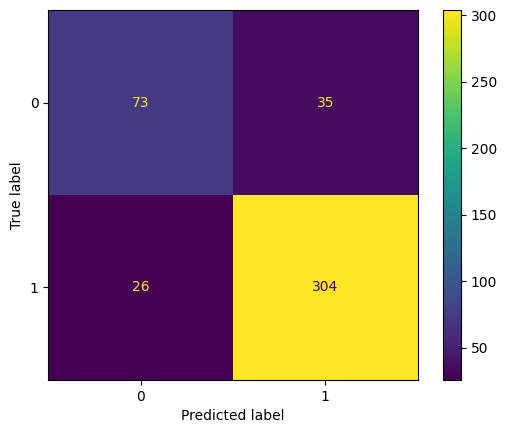

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_rf.classes_)
disp.plot()

plt.show()

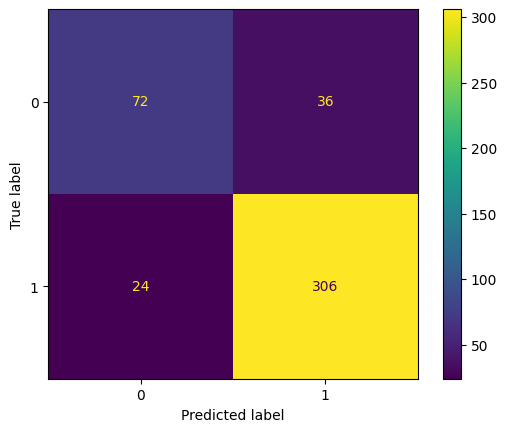

In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_bayes, labels=clf_rf_bayes.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_rf_bayes.classes_)
disp.plot()

plt.show()

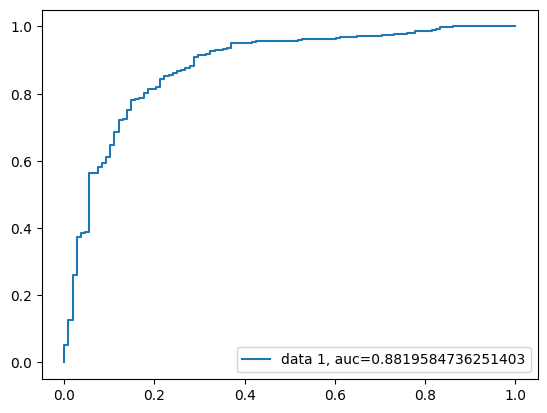

In [115]:
from sklearn import metrics

y_pred_proba = clf_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [116]:
from sklearn.metrics import precision_recall_curve

y_probs = clf_rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

import statistics
# Select threshold where precision and recall are balanced
optimal_idx = ((2*precision*recall)/(precision+recall)).argmax()
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)
# Make new predictions
y_pred_new = (y_probs > optimal_threshold).astype(int)

0.41814957133326996


In [117]:
optimal_threshold 

0.41814957133326996

In [118]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8607
Precision: 0.8968
Recall: 0.9212
F1-score: 0.9088

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.68      0.71       108
           1       0.90      0.92      0.91       330

    accuracy                           0.86       438
   macro avg       0.82      0.80      0.81       438
weighted avg       0.86      0.86      0.86       438



In [119]:
accuracy = accuracy_score(y_test, y_pred_bayes)
precision = precision_score(y_test, y_pred_bayes)
recall = recall_score(y_test, y_pred_bayes)
f1 = f1_score(y_test, y_pred_bayes)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_bayes))

Accuracy: 0.8630
Precision: 0.8947
Recall: 0.9273
F1-score: 0.9107

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71       108
           1       0.89      0.93      0.91       330

    accuracy                           0.86       438
   macro avg       0.82      0.80      0.81       438
weighted avg       0.86      0.86      0.86       438



In [168]:
X_test_scaled = scaler.transform(test_final)
X_test_pca = pca.transform(X_test_scaled)
y_pred_submit = clf_rf.predict_proba(X_test_pca)[:, 1] 
submission = pd.DataFrame({
    "id": test["id"],  # Include ID column
    "rainfall": y_pred_submit  # Change to y_proba_kaggle if required
})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [169]:
y_pred_submit

array([0.96618815, 0.97362644, 0.88963176, 0.26503007, 0.25649177,
       0.46632954, 0.64175365, 0.89630949, 0.80631861, 0.66217389,
       0.94128836, 0.10813596, 0.92518344, 0.95086142, 0.25874908,
       0.14463765, 0.72278476, 0.4221965 , 0.13689443, 0.17604937,
       0.48787284, 0.46175685, 0.60824927, 0.94847923, 0.89046662,
       0.41410544, 0.27964073, 0.85490459, 0.91628071, 0.39448414,
       0.85560323, 0.95810083, 0.82084432, 0.92722598, 0.76016946,
       0.89677792, 0.2200818 , 0.8213241 , 0.79856424, 0.69230611,
       0.76083004, 0.79288885, 0.22203938, 0.75375964, 0.86323118,
       0.09890673, 0.29082849, 0.92023969, 0.12067185, 0.58105706,
       0.86879724, 0.96149242, 0.94676551, 0.95017431, 0.95917112,
       0.95803305, 0.94253017, 0.94857445, 0.91322853, 0.97098243,
       0.9354472 , 0.95292009, 0.96204058, 0.86336617, 0.39615611,
       0.30866666, 0.28138268, 0.58314952, 0.70479336, 0.412403  ,
       0.92404935, 0.86534542, 0.91164404, 0.96735155, 0.96522

In [172]:
submission.to_csv('submission_ver4_rf_pca_smote.csv',index=False)

In [171]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Print feature importance
print(feature_importance)

  Feature  Importance
1     PC2    0.487859
3     PC4    0.122621
0     PC1    0.085554
5     PC6    0.052493
6     PC7    0.051290
7     PC8    0.051010
4     PC5    0.045078
2     PC3    0.040656
8     PC9    0.031816
9    PC10    0.031623


In [132]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,  
    learning_rate=0.01,  
    max_depth=4,  
    subsample=0.8,  # Row sampling
    colsample_bytree=0.8,  # Feature sampling
    random_state=42,
    min_samples_leaf=round(len(X_train)/100)
)

# Fit the model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:53:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, min_samples_leaf=18, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [133]:
y_pred = xgb_model.predict(X_test)

In [134]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8721
Precision: 0.8960
Recall: 0.9394
F1-score: 0.9172

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.67      0.72       108
           1       0.90      0.94      0.92       330

    accuracy                           0.87       438
   macro avg       0.84      0.80      0.82       438
weighted avg       0.87      0.87      0.87       438



In [142]:

from skopt.space import Categorical, Integer, Real
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

# Define the Bayesian search space
search_space = {
    # SMOTE Parameters
    'smote__sampling_strategy': Categorical([0.5, 0.7, 'auto']),
    'smote__k_neighbors': Integer(3, 15),  # Number of neighbors for SMOTE

    # XGBoost Parameters
    'model__n_estimators': Integer(100, 500),
    'model__max_depth': Integer(3, 15),
    'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'model__subsample': Real(0.5, 1.0),
    'model__colsample_bytree': Real(0.5, 1.0),
    'model__gamma': Real(0, 5),
    'model__min_child_weight': Integer(1, 10),
    'model__reg_alpha': Real(0, 10),  # L1 regularization
    'model__reg_lambda': Real(0, 10),  # L2 regularization
    'model__max_delta_step': Integer(0, 10),  # Useful for highly imbalanced data
    'model__colsample_bylevel': Real(0.5, 1.0),  # Column sampling per tree level
    'model__colsample_bynode': Real(0.5, 1.0)  # Column sampling per node
}

# Bayesian optimization using BayesSearchCV
xgb_bayes_search = BayesSearchCV(
    pipeline,
    search_spaces=search_space,
    n_iter=50,  # Number of parameter sets to evaluate
    cv=5,
    scoring="f1",
    n_jobs=-1,
    random_state=42
)

# Fit search to data
xgb_bayes_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", xgb_bayes_search.best_params_)


Best Parameters: OrderedDict([('model__colsample_bylevel', 0.7717015338451563), ('model__colsample_bynode', 0.9600046132186582), ('model__colsample_bytree', 0.7482333517983584), ('model__gamma', 4.188282185302634), ('model__learning_rate', 0.030107582677977363), ('model__max_delta_step', 1), ('model__max_depth', 10), ('model__min_child_weight', 1), ('model__n_estimators', 254), ('model__reg_alpha', 8.25945956447921), ('model__reg_lambda', 3.67447278986657), ('model__subsample', 0.7863782125617294), ('smote__k_neighbors', 11), ('smote__sampling_strategy', 0.5)])


In [143]:
best_xgb_bayes_params = xgb_bayes_search.best_params_
print("Best Parameters:", best_xgb_bayes_params)

best_smote_strategy = best_xgb_bayes_params['smote__sampling_strategy']
best_smote_neighbours = best_xgb_bayes_params['smote__k_neighbors']

# Apply SMOTE separately
smote = SMOTE(sampling_strategy=best_smote_strategy, random_state=42,k_neighbors=best_smote_neighbours)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

xgb_params = {k.replace('model__', ''): v for k, v in best_xgb_bayes_params.items() if k.startswith('model__')}

# **Step 2: Train final XGBoost model with best parameters**
best_xgb = xgb.XGBClassifier(**xgb_params,
    random_state=42
)

# Train final model
best_xgb.fit(X_resampled, y_resampled)


Best Parameters: OrderedDict([('model__colsample_bylevel', 0.7717015338451563), ('model__colsample_bynode', 0.9600046132186582), ('model__colsample_bytree', 0.7482333517983584), ('model__gamma', 4.188282185302634), ('model__learning_rate', 0.030107582677977363), ('model__max_delta_step', 1), ('model__max_depth', 10), ('model__min_child_weight', 1), ('model__n_estimators', 254), ('model__reg_alpha', 8.25945956447921), ('model__reg_lambda', 3.67447278986657), ('model__subsample', 0.7863782125617294), ('smote__k_neighbors', 11), ('smote__sampling_strategy', 0.5)])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7717015338451563,
              colsample_bynode=0.9600046132186582,
              colsample_bytree=0.7482333517983584, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.188282185302634,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.030107582677977363,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=1, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=254, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [144]:
y_pred = best_xgb.predict(X_test)

In [154]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8562
Precision: 0.8985
Recall: 0.9121
F1-score: 0.9053

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.70       108
           1       0.90      0.91      0.91       330

    accuracy                           0.86       438
   macro avg       0.81      0.80      0.80       438
weighted avg       0.85      0.86      0.86       438



In [160]:
test_final.shape

(730, 54)

In [173]:
X_test_scaled = scaler.transform(test_final)
X_test_pca = pca.transform(X_test_scaled)
y_pred_submit = best_xgb.predict_proba(X_test_pca)[:, 1] 
submission = pd.DataFrame({
    "id": test["id"],  # Include ID column
    "rainfall": y_pred_submit  # Change to y_proba_kaggle if required
})

In [174]:
print("Predicted Probabilities:", y_pred_submit[:10])


Predicted Probabilities: [0.93826973 0.9352036  0.8775543  0.21807897 0.20663616 0.50418687
 0.80889404 0.89384705 0.8057347  0.7034281 ]


In [175]:
submission = pd.DataFrame({
    "id": test["id"],  # Include ID column
    "rainfall": y_pred_submit  # Change to y_proba_kaggle if required
})

## Logistic Regression

In [176]:
submission.to_csv('submission_ver5_xgb_smote_final.csv',index=False)

In [208]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid = {
    'smote__sampling_strategy': [0.5, 0.7, 'auto'],
    'smote__k_neighbors': [2,3, 5, 7],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# smote = SMOTE(sampling_strategy=0.75, random_state=42,k_neighbors=1)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# log_reg = LogisticRegression()

# log_reg.fit(X_resampled, y_resampled)

# y_pred = log_reg.predict(X_test)


Best Parameters: {'model__C': 1, 'model__penalty': 'l1', 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.5}
Best Recall Score: 0.9166666666666666


In [209]:
y_pred = grid_search.best_estimator_.predict(X_test)


In [210]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8653
Precision: 0.9021
Recall: 0.9212
F1-score: 0.9115

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.72       108
           1       0.90      0.92      0.91       330

    accuracy                           0.87       438
   macro avg       0.82      0.81      0.81       438
weighted avg       0.86      0.87      0.86       438



In [190]:
X_test_scaled = scaler.transform(test_final)
X_test_pca = pca.transform(X_test_scaled)
y_pred_submit = log_reg.predict_proba(X_test_pca)[:, 1] 
submission = pd.DataFrame({
    "id": test["id"],  
    "rainfall": y_pred_submit 
})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [191]:
submission.to_csv('submission_ver6_logreg_smote.csv',index=False)

## Support Vector Machine

In [215]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
])

In [1]:
search_space = {
    'smote__sampling_strategy': Categorical([0.5, 0.7, 'auto']),
    'smote__k_neighbors': Integer(3, 10),
    'svc__C': Real(0.1, 100, prior='log-uniform'),
    'svc__gamma': Real(1e-4, 1e1, prior='log-uniform'),
    'svc__kernel': Categorical(['rbf', 'poly', 'sigmoid']),
    'svc__degree': Integer(2, 5),  # Only used if kernel='poly'
    'svc__class_weight': Categorical([None, 'balanced'])
}

bayes_search = BayesSearchCV(
    pipeline,
    search_space,
    n_iter=50,
    cv=5,
    scoring='recall',
    random_state=42,
    n_jobs=-1
)

bayes_search.fit(X_train, y_train)
print("Best Parameters:", bayes_search.best_params_)


NameError: name 'Categorical' is not defined

In [ ]:
best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# num_bins = 10  

# binned_means = {}

# for i, var in enumerate(X_test.columns):
#     df_test[f'{var}_bin'] = pd.qcut(df_test[var], q=num_bins, duplicates='drop')
#     mean_values = df_test.groupby(f'{var}_bin')[['rainfall', 'y_pred']].mean().reset_index()
    
#     # Store in dictionary
#     binned_means[var] = mean_values

# dfs = []
# for var, means in binned_means.items():
#     means = means.copy()  # Avoid modifying original data
#     means['Variable'] = var  # Add a column to identify the variable
#     means.rename(columns={means.columns[0]: 'Range', means.columns[1]: 'Mean_Target', means.columns[2]: 'Mean_Predicted'}, inplace=True)
#     dfs.append(means)

# # Combine all into one DataFrame
# combined_df = pd.concat(dfs, ignore_index=True)

# # Save to CSV
# combined_df.to_csv('binned_means_all.csv', index=False)
